In [1]:
%cd /workspace
%load_ext autoreload
%autoreload 2

/workspace


In [2]:
from src.datasets import EvalFFHQ


dataset = EvalFFHQ(
    'data/wspace_ffhq_feat.npy',
    'data/sspace_ffhq_feat.npy',
    'data/cspace_ffhq_feat.npy',
    limit=30
)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
from torch.utils.data import DataLoader

loader = DataLoader(dataset, batch_size=16)

In [15]:
batch = next(loader.__iter__())

In [16]:
from src.models.delta_edit import DeltaEditInferencer

inferencer = DeltaEditInferencer(
    stylegan2_path='saved/stylegan2/stylegan2-ffhq-config-f.pt',
    relevance_matrix_path='saved/stylegan2/fs3.npy',
    clip_ckpt='ViT-B/32',
    delta_mapper_ckpt='saved/models/net_face.pth',
    device='cuda:1',
    stylegan_size=1024,
    style_dim=512,
    threshold=0.03
)

In [78]:
neutral_prompt = 'face'
text_prompt = 'face with blond hair'

In [79]:
gen, src = inferencer(**batch, text_prompt=text_prompt, neutral_prompt=neutral_prompt)

In [80]:
gen.shape, src.shape

(torch.Size([16, 3, 1024, 1024]), torch.Size([16, 3, 1024, 1024]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


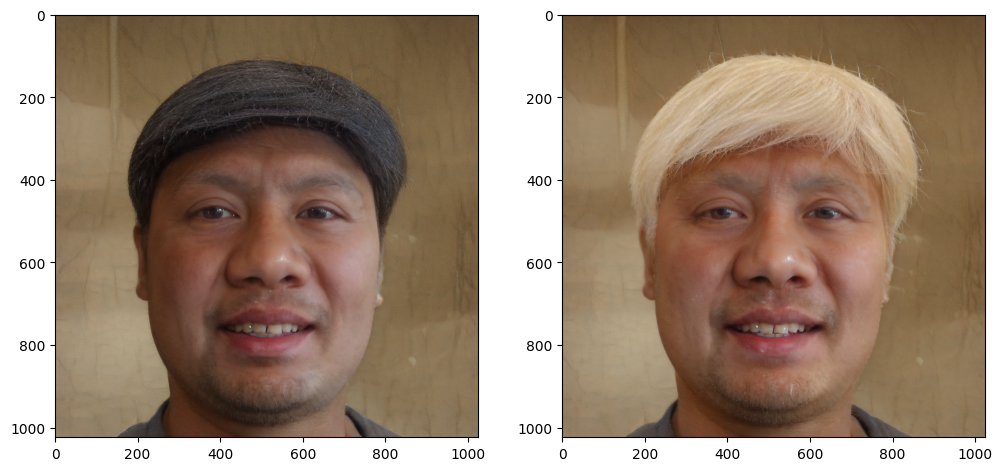

In [81]:
import random
import matplotlib.pyplot as plt

# ind =  random.randint(0, 15)
ind = 0

_, axs = plt.subplots(ncols=2, figsize=(12, 6))

axs[0].imshow(src[ind].permute(1, 2, 0).detach().cpu() * 0.5 + 0.5)
axs[1].imshow(gen[ind].permute(1, 2, 0).detach().cpu() * 0.5 + 0.5)

In [82]:
gen.shape

torch.Size([16, 3, 1024, 1024])

In [83]:
sample = gen[0]
sample.shape

torch.Size([3, 1024, 1024])

In [67]:
from src.losses import CLIPLoss

In [113]:
clip_score = CLIPLoss(1024, inferencer.clip_model, 'cuda:1')

In [114]:
text = 'face with blond hair'

In [115]:
score = clip_score(gen, text)
score

tensor([[0.3212],
        [0.2604],
        [0.2745],
        [0.2696],
        [0.2513],
        [0.2324],
        [0.2328],
        [0.2241],
        [0.2433],
        [0.2765],
        [0.2759],
        [0.2708],
        [0.2450],
        [0.2453],
        [0.2822],
        [0.2213]], device='cuda:1', grad_fn=<MmBackward0>)

In [116]:
score.shape

torch.Size([16, 1])

In [117]:
score.mean()

tensor(0.2579, device='cuda:1', grad_fn=<MeanBackward0>)

In [112]:
score.shape

torch.Size([16, 16])

In [101]:
import clip
import torch

encoded = clip_score.model.encode_text(torch.cat([clip.tokenize(text)]).to(clip_score.device))

In [102]:
encoded.shape

torch.Size([1, 512])

In [107]:
encoded.repeat(3, 1).shape

torch.Size([3, 512])